In [20]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import lfilter, correlate
from IPython.display import Audio

In [21]:
file_path = r"C:\Users\sanja\Downloads\dev-clean\LibriSpeech\dev-clean\2902\9006\2902-9006-0000.flac"
signal, sample_rate = sf.read(file_path)

In [22]:
# Display audio properties
print(f'Sample Rate: {sample_rate} Hz')
print(f'Signal Length: {len(signal)} samples')

Sample Rate: 16000 Hz
Signal Length: 76800 samples


In [23]:
# Ensure mono signal
if len(signal.shape) == 2:
    signal = np.mean(signal, axis=1)

In [24]:
# Normalize the signal
signal = signal / np.max(np.abs(signal))


In [25]:
# Play the original speech signal
print("Original Signal:")
display(Audio(data=signal, rate=sample_rate))

Original Signal:


In [26]:
# Function to compute LPC coefficients
def autocorrelate(signal, order):
    r = correlate(signal, signal, mode='full')[-len(signal):]
    return r[:order + 1]

In [27]:
def lpc(signal, order):
    r = autocorrelate(signal, order)
    
    # Ensure we do not exceed the size of the autocorrelation array
    R = np.zeros((order, order))
    
    for i in range(order):
        # Adjust slicing to avoid broadcasting errors
        R[i, :order - i] = r[i:order]
    
    # Solve for LPC coefficients using the Yule-Walker equations
    C = np.linalg.solve(R, r[1:order + 1])
    
    # Return LPC coefficients with leading 1
    return np.concatenate(([1], -C))

In [28]:
# Set LPC order (Make sure order is suitable for signal length)
lpc_order = min(12, len(signal) - 1)

In [29]:
# Get LPC coefficients
lpc_coefficients = lpc(signal, lpc_order)
print("LPC Coefficients:", lpc_coefficients)

LPC Coefficients: [ 1.         -1.19677878 -0.10406009 -0.11408298 -0.15316982 -0.1738834
 -0.22370733 -0.29934286 -0.32539526 -0.42768999 -0.51903207 -0.64235939
 -0.82815908]


In [30]:
# Reconstruct the speech signal using LPC coefficients
reconstructed_signal = lfilter([0] + -lpc_coefficients[1:], [1], signal)

In [31]:
# Play the reconstructed speech signal
print("Reconstructed Signal:")
display(Audio(data=reconstructed_signal, rate=sample_rate))

Reconstructed Signal:


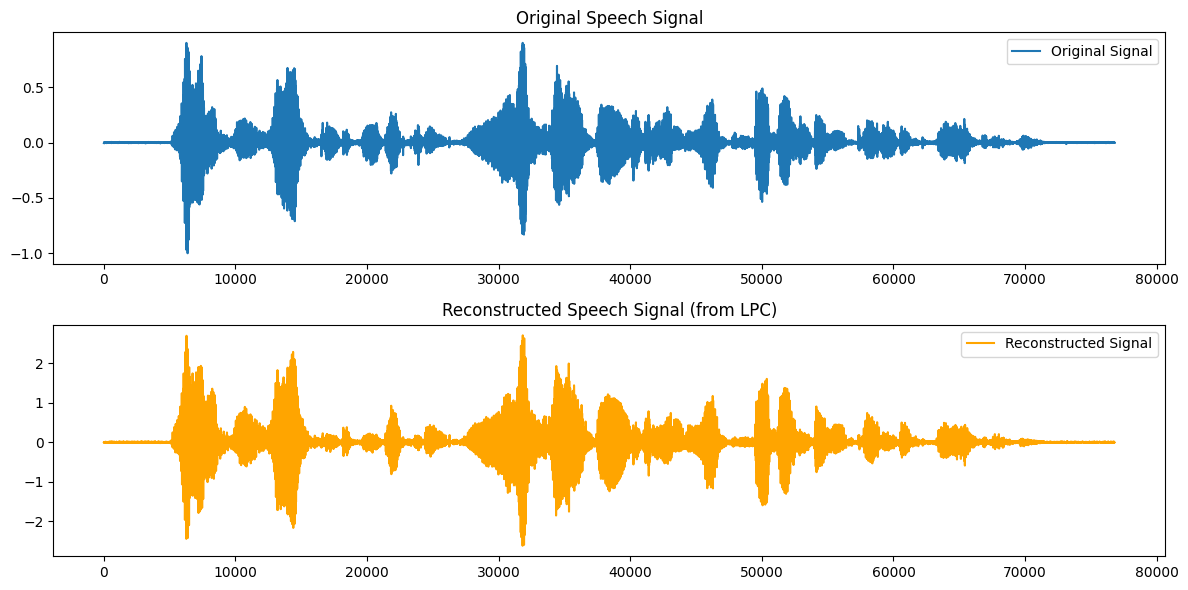

In [32]:
# Plot original and reconstructed signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(signal, label="Original Signal")
plt.title("Original Speech Signal")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(reconstructed_signal, label="Reconstructed Signal", color='orange')
plt.title("Reconstructed Speech Signal (from LPC)")
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
# Function to estimate formant frequencies from LPC
def formant_frequencies(lpc_coeffs, sample_rate):
    roots = np.roots(lpc_coeffs)
    roots = [r for r in roots if np.imag(r) >= 0.01]  # Filter only positive frequencies
    angles = np.angle(roots)
    formant_freqs = sorted(angles * (sample_rate / (2 * np.pi)))
    return formant_freqs


Estimated Formant Frequencies: [1277.5120656673507, 2594.621144050755, 3949.962222433278, 5287.539430695672, 6657.439844580017]


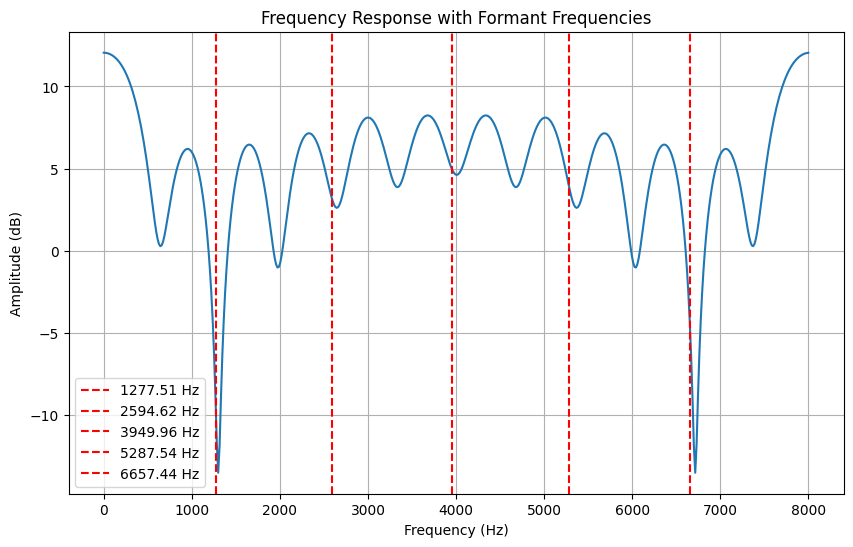

In [34]:
# Estimate formants
formants = formant_frequencies(lpc_coefficients, sample_rate)
print("Estimated Formant Frequencies:", formants)

# Plot frequency response and formants
w, h = np.linspace(0, np.pi, 512), np.fft.fft(lpc_coefficients, 512)

plt.figure(figsize=(10, 6))
plt.plot(w * (sample_rate / (2 * np.pi)), 20 * np.log10(np.abs(h)))
plt.title("Frequency Response with Formant Frequencies")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")

for formant in formants:
    plt.axvline(x=formant, color='red', linestyle='--', label=f'{formant:.2f} Hz')

plt.legend()
plt.grid()
plt.show()